<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/submission_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 환경 설정

필요한 패키지 불러오기

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install konlpy
!pip install transformers-interpret

matplotlib 한글 깨짐 해결

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

mecab 설치

In [ ]:
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

#### 해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

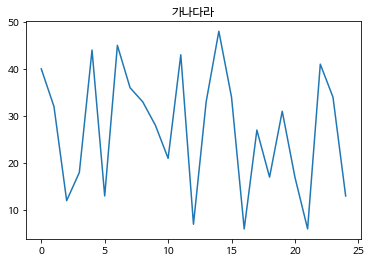

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### 구글 드라이브와 코랩 연결

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun')

Mounted at /content/drive


## 2. 데이터 불러오기

In [ ]:
ls ../../data/senti_kor_sns_5000_bt.csv

AI_HUB/                        senti_kor_sns_5000_koeda.csv
aihub_total.txt                senti_kor_sns_summary_5000_bt.csv
augmented_files/               sns_pred_data/
senti_kor_sns_5000_allaug.csv  total.csv
senti_kor_sns_5000_bt.csv      TUNiB/
senti_kor_sns_5000.csv


In [ ]:
import pandas as pd

tmp = pd.read_csv("../../data/senti_kor_sns_5000_bt.csv")
tmp.groupby("class").count()

,Unnamed: 0,conversation
class,,
0,3584,3584
1,3924,3924
2,3916,3916
3,4376,4376
4,15346,15346


#### TUNiB 데이터 불러오기

In [ ]:
import pandas as pd

tunib_train = pd.read_csv("../../data/TUNiB/train.csv")
tunib_train = tunib_train[["class", "conversation"]]

#### 증강 데이터 불러오기

In [ ]:
from glob import glob

aug_path = glob("../../data/augmented_files/*")
bt_aug_path = [path for path in aug_path if "bt" in path]

aug_train = pd.DataFrame()
for path in bt_aug_path:
  tmp = pd.read_csv(path, index_col = [0])
  aug_train = pd.concat([aug_train, tmp], axis = 0)

aug_train = aug_train.reset_index(drop=True)
aug_train = aug_train.rename(columns = {"x_train":"conversation", "y_train":"class"})
aug_train = aug_train[["class", "conversation"]]
print(aug_train.shape)
aug_train.head()

(11850, 2)


,class,conversation
0,0,지금 당신 자신을 죽이고 싶지 않아요. 당신이 죽으면 혼자 죽을 테니까 우리까지 사...
1,0,길동 경찰입니다. 9시 40분에 마트에 폭발물을 설치하겠습니다.
2,3,너 참 귀엽다는 걸 알고 있어 나보다 작은 남자는 곁에 있었어 그만 놀리는 건 재미...
3,1,여기 오시면 옷이 잘 보입니다. 돈이 좀 없는 것 같아요. 늦으면 죽을 거예요. 오...
4,1,"미안합니다. 혹시 너무 더워요. 우리 회사에서 이 생크림을 팔고 있는데, 한번 손에..."


In [ ]:
def id2label(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == 0:
    return "협박 대화"
  elif x == 1:
    return "갈취 대화"
  elif x == 2:
    return "직장 내 괴롭힘 대화"
  elif x == 3:
    return "기타 괴롭힘 대화"
  elif x == 4:
    return "일반 대화"

In [ ]:
aug_train["class"] = aug_train["class"].apply(id2label)
aug_train.head()

,class,conversation
0,협박 대화,지금 당신 자신을 죽이고 싶지 않아요. 당신이 죽으면 혼자 죽을 테니까 우리까지 사...
1,협박 대화,길동 경찰입니다. 9시 40분에 마트에 폭발물을 설치하겠습니다.
2,기타 괴롭힘 대화,너 참 귀엽다는 걸 알고 있어 나보다 작은 남자는 곁에 있었어 그만 놀리는 건 재미...
3,갈취 대화,여기 오시면 옷이 잘 보입니다. 돈이 좀 없는 것 같아요. 늦으면 죽을 거예요. 오...
4,갈취 대화,"미안합니다. 혹시 너무 더워요. 우리 회사에서 이 생크림을 팔고 있는데, 한번 손에..."


In [ ]:
total_data = pd.read_csv("../../data/senti_kor_sns_5000.csv", index_col = [0])
print(len(total_data))
total_data = pd.concat([total_data, aug_train], axis = 0)
total_data = total_data.reset_index(drop=True)
total_data

19296


,class,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,0,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...
31141,3,"준샤, 왜 이렇게 큰 거야? 내 머릿속에 뭐가 들어있어? 큰 사람이라고 말하지 않았..."
31142,1,"내가 지금 당신 아들을 데리고 있다면, 당신이 그를 구하려고 하면, 그냥 돈을 보내..."
31143,2,당신 같은 사람을 보면 어떻게 이렇게 살 수 있을까요? 왜 그렇게 말하는 거죠? 지...
31144,1,"여기서 무슨 일을 하든 경찰에 신고하고 정식으로 사업을 해야 하는데, 어디든 우리 ..."


In [ ]:
total_data.to_csv("../../data/senti_kor_sns_5000_bt.csv")

#### AI_HUB 데이터 불러오기

In [ ]:
from glob import glob

aihub_train_path = glob("../../data/AI_HUB/*")

aihub_train = pd.DataFrame()
for path in aihub_train_path:
  tmp = pd.read_csv(path)[["class", "conversation"]]
  if len(tmp) >= 5000:
    tmp = tmp.sample(5000)
    aihub_train = pd.concat([aihub_train, tmp], axis = 0)
  else:
    aihub_train = pd.concat([aihub_train, tmp], axis = 0)

In [ ]:
aihub_train = aihub_train.drop_duplicates(keep="first")
aihub_train

,class,conversation
3336,일반 대화,여기 마우스가 작동이 안 돼요\n제가 봐드릴게요\n이렇게 아무리 눌러도 인식이 안돼...
1345,일반 대화,여기 진열되어 있는 점퍼 얼마인가요?\n8만원입니다\n입어볼 수 있나요?\n네 가능...
570,일반 대화,지금 배달 되나요?\n네 11시까지 배달됩니다\n그럼 짜장면1개 탕수육1개 배달해주...
877,일반 대화,이거 여행 가방인 거죠?\n네\n이거 색깔이 무슨 색이라 해야 되나?\n갈색이죠\n...
4069,일반 대화,돼지고기 등심은 어디에 있어요?\n맨 왼쪽 파티션 안에 돼지고기 등심 있어요\n국거...
...,...,...
176221,일반 대화,헐\n후디 열두시반공연이었네\n엉엉\n아..\nㅠㅠ\n님 창모 보러 가시는 것 아님...
208083,일반 대화,멀.어쩌겠어 ㅋ\n욕 디지게 먹겠군 떼잉\n하든지말던지\n그려\n너는 너갈길 하믄도...
67603,일반 대화,나얼굴이 완전건조하고 메말라잇는원인을\n찾앗어\n고생햇더~\n왜왜\n사무실에\n히터...
54183,일반 대화,형은어제쯤온대?\n와서뭐하시나\n오래있나?\n애도 아픈데 집에서 쏘주나한잔\n월욜오...


#### AI_HUB 데이터와 TUNiB 데이터를 합친 뒤 전처리 적용

In [ ]:
train = pd.concat([tunib_train, aug_train, aihub_train], axis = 0)
train

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...
176221,일반 대화,헐\n후디 열두시반공연이었네\n엉엉\n아..\nㅠㅠ\n님 창모 보러 가시는 것 아님...
208083,일반 대화,멀.어쩌겠어 ㅋ\n욕 디지게 먹겠군 떼잉\n하든지말던지\n그려\n너는 너갈길 하믄도...
67603,일반 대화,나얼굴이 완전건조하고 메말라잇는원인을\n찾앗어\n고생햇더~\n왜왜\n사무실에\n히터...
54183,일반 대화,형은어제쯤온대?\n와서뭐하시나\n오래있나?\n애도 아픈데 집에서 쏘주나한잔\n월욜오...


In [ ]:
train.groupby("class").count()

,conversation
class,
갈취 대화,3924
기타 괴롭힘 대화,4376
일반 대화,20341
직장 내 괴롭힘 대화,3916
협박 대화,3584


In [ ]:
def label2id(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == "협박 대화":
    return 0
  elif x == "갈취 대화":
    return 1
  elif x == "직장 내 괴롭힘 대화":
    return 2
  elif x == "기타 괴롭힘 대화":
    return 3
  elif x == "일반 대화":
    return 4

def preprocessing(x):
  # 한글, 숫자, ?!,. 를 제외하고는 모든 str을 공백으로 대체합니다.
  x = re.sub("[^ㄱ-ㅎ가-힣0-9?!,.]", " ", x)
  # 연속적인 공백을 한칸 공백으로 대체합니다.
  x = re.sub("[ ]+", " ", x)
  # 양쪽 공백을 제거합니다.
  x = x.strip()
  return x

In [ ]:
# 앞선 함수를 데이터셋에 적용합니다.
from tqdm import tqdm
import re
train["class"] = train["class"].apply(label2id)
tqdm.pandas()
train["conversation"] = train["conversation"].progress_apply(preprocessing)
train = train.reset_index(drop=True)
train.head()

100%|██████████| 36141/36141 [00:01<00:00, 33854.18it/s]


,class,conversation
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,0,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [ ]:
train.groupby("class").count()

,conversation
class,
0,3584
1,3924
2,3916
3,4376
4,20341


#### 학습을 위해서 만들어진 데이터셋 csv 파일로 저장

In [ ]:
train.to_csv("../../data/senti_kor_sns_summary_5000_bt.csv")

## 3. 모델 클래스 및 함수 

#### 데이터 로딩 클래스

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

class DataLoad():


  def __init__(self, data_path):
    self.dataset = pd.read_csv(data_path)


  def split(self, split_size):
    X = self.dataset["conversation"]
    Y = self.dataset["class"]
    print(self.dataset.groupby("class").count().iloc[:,0])
    print(self.dataset.head())
    # 전체 데이터의 split_size 비율 만큼은 테스트, 검증 데이터입니다.
    x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = split_size, 
                                                            random_state = 200,
                                                            stratify = Y)
    # 테스트, 검증 데이터의 개수는 1:1의 비율을 가집니다.
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
    print(f"x_train 개수 : {len(x_train)}")
    print(f"y_train 개수 : {len(y_train)}")
    print(f"x_val 개수 : {len(x_val)}")
    print(f"y_val 개수 : {len(y_val)}")
    print(f"x_test 개수 : {len(x_test)}")
    print(f"y_test 개수 : {len(y_test)}")
    print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
    print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
    print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")
    return x_train.tolist(), x_val.tolist(), x_test.tolist(), y_train.tolist(), y_val.tolist(), y_test.tolist()

#### 데이터 증강 클래스

In [ ]:
import random
import gensim
from konlpy.tag import Mecab
from tqdm import tqdm

class DataAugmentation:


  def __init__(self, X, Y, word2vec_path):
    self.mecab = Mecab()
    self.word2vec = gensim.models.Word2Vec.load(word2vec_path)
    self.X = X
    self.Y = Y
  
  def sub_rep(self, X, sub_ratio = 0.1):
    # 전체 단어중에서 sub_ratio 만큼만 무작위 선택합니다.
    nouns = list(set(self.mecab.morphs(X)))
    sub_num = int(len(nouns) * sub_ratio)
    sub_list = random.sample(nouns, sub_num)

    # 대체 시킬 단어와 유사한 단어들을 불러옵니다.
    result = []
    for sub in sub_list:
      try:
        result.append((sub, self.word2vec.wv.most_similar(sub)[0]))
      except KeyError:
        pass
    result = list(map(lambda x: (x[0], x[1][0]), result))

    # 무작위 선택된 단어들을 유사한 단어들로 바꿔줍니다.
    for before, after in result:
      X = X.replace(before, after, 1)
    return X

  def sub_rep_dataset(self, sub_ratio = 0.1):
    # 입력 X에 sub_rep 함수 적용합니다.
    new_x = list(tqdm(map(lambda x: self.sub_rep(x, sub_ratio), self.X)))
    # 입력 Y의 값을 복사합니다.
    new_y = self.Y.copy()

    print("훈련 데이터 유의어 대체 증강 완료")
    print(f"증강시킨 데이터 개수 : {len(new_x)}")
    print(f"----데이터 증강 전 데이터 예시 ----\n{self.X[0]}")
    print(f"----데이터 증강 후 데이터 예시 ----\n{new_x[0]}")
    return new_x, new_y

  def label_repeat(self, label_id, num = 1):
    # 특정 레이블 label_id를 num 횟수 만큼 반복
    new_x = []
    new_y = []
    for i in range(num):
      label_index = (np.array(self.Y) == label_id)
      new_x += np.array(self.X)[label_index].tolist()
      new_y += np.array(self.Y)[label_index].tolist()
    
    print("훈련 데이터 특정 레이블 반복 증강 완료")
    print(f"반복되는 레이블 id : {label_id}")
    print(f"반복된 횟수 : {num}")
    return new_x, new_y

#### 기타 함수 

In [ ]:
def id2label(x):
  # id에 맞는 실제 클래스로 변환시킵니다.
  if x == 0:
    return "협박 대화"
  elif x == 1:
    return "갈취 대화"
  elif x == 2:
    return "직장 내 괴롭힘 대화"
  elif x == 3:
    return "기타 괴롭힘 대화"
  elif x == 4:
    return "일반 대화"


def clf_score(y_test, y_pred):
  # 테스트 데이터에서 오분류된 데이터들의 idx를 리스트 타입으로 반환합니다.
  # classification report 
  false_list = [idx for idx, i in enumerate(y_test) if y_pred[idx] != i]
  print(f"모델이 틀린 데이터 개수 {len(false_list)}개")
  print(classification_report(y_test, y_pred))

  # confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
  conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
  sns.heatmap(conf_matrix, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("pred")
  plt.ylabel("true")
  plt.show()
  return false_list


def evaluate_result(score_list, x_test, y_pred, y_test):
  # 입력, 예측값, 실제값, 레이블별 score로 이루어진 판다스 데이터셋을 반환합니다.
  score_dataset = pd.DataFrame(score_list).add_prefix("label_")
  label_dataset = pd.DataFrame({"x_test":x_test, "y_pred":y_pred, "y_test":y_test})
  test_dataset = pd.concat([label_dataset, score_dataset], axis = 1)
  return test_dataset


def false_case_dataset(false_list, x_test, y_test, y_pred, print_example = False):
  # 오분류된 idx에 맞는 입력, 예측값, 실제값을 담은 리스트를 반환합니다.
  false_x_test = [x_test[i] for i in false_list]
  false_y_test = [y_test[i] for i in false_list]
  false_y_pred = [y_pred[i] for i in false_list]

  # 앞서 담은 리스트들을 판다스 데이터프레임 타입으로 변환시킵니다.
  false_dataset = pd.DataFrame({"text":false_x_test, "y_true":false_y_test, "y_pred":false_y_pred})
  # 숫자로된 id를 실제 레이블로 바꾸며 예시는 '0 -> 협박 대화' 입니다.
  false_dataset["y_true"] = false_dataset["y_true"].apply(lambda x : id2label(x))
  false_dataset["y_pred"] = false_dataset["y_pred"].apply(lambda x : id2label(x))

  # 오분류 예제의 내용을 보고 싶으면 print_example argument를 True로 바꿉니다.
  if print_example:
    for i in range(len(false_dataset)):
      sentence, prediction, real =false_dataset.iloc[i, :]
      print(f"예측 분류 : {prediction}")
      print(f"실제 분류 : {real}")
      print(sentence)
      print("\n")
  return false_dataset  


def save_csv(df, path, name):
  try:
    os.mkdir(path)
  except:
    pass
  new_path = os.path.join(path, name)
  df.to_csv(new_path)


def scheduler(epoch, lr):
  if epoch < 1:
    return lr
  else:
    return lr * 0.2

#### Huggingface 모델 파이프라인 클래스

In [ ]:
import os
import re
import tensorflow as tf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel


class TFGPT2ForSequenceClassification(tf.keras.Model):
  """
  GPT모델은 따로 출력층에 softmax 레이어를 추가해야 합니다.
  """
  def __init__(self, model_name, num_labels):
      super(TFGPT2ForSequenceClassification, self).__init__()
      self.gpt = TFAutoModel.from_pretrained(model_name, 
                                              from_pt=True)
      self.classifier = tf.keras.layers.Dense(num_labels,
                                              kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                              activation='softmax',
                                              name='classifier')

  def call(self, inputs):
      outputs = self.gpt(input_ids=inputs)
      cls_token = outputs[0][:, -1]
      prediction = self.classifier(cls_token)

      return prediction


class TrainPipeline:
  def __init__(self, model_path, num_labels, batch_size = 16, epochs = 1):
    """
    Args:
      - model_path : Hugginface에서 사전학습된 모델들의 주소 str값을 받습니다.
      - num_labels : 분류되는 클래스의 개수 int값을 받습니다.
      - batch_size : 배치마다 들어가는 데이터의 개수 int값을 받습니다.
      - epochs : 모델이 학습하는 에폭 수 int값을 받습니다.
    Desc:
      - 데이터셋 구축, 모델 훈련, 저장, 검증의 과정을 거치는 훈련 파이프라인
    """
    self.model_path = model_path
    self.batch_size = batch_size
    self.epochs = epochs
    self.num_labels = num_labels
    if "output_bert" in self.model_path:
      self.tokenizer = AutoTokenizer.from_pretrained("klue/bert-base",
                                                    bos_token='</s>', 
                                                    eos_token='</s>', 
                                                    pad_token='<pad>')
    else:
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_path,
                                                    bos_token='</s>', 
                                                    eos_token='</s>', 
                                                    pad_token='<pad>')
    if "output_bert" in self.model_path:
      self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path,
                                                                        num_labels = self.num_labels)
    else:
      self.model = TFAutoModelForSequenceClassification.from_pretrained(self.model_path,
                                                                        num_labels = self.num_labels,
                                                                        from_pt=True)
    # https://stackoverflow.com/questions/69191305/how-to-add-new-special-token-to-the-tokenizer
    # 추가된 토큰에 맞게 vocab_size 재지정
    self.model.resize_token_embeddings(len(self.tokenizer))

  def dataset(self, X, Y, lstm = False):
    """
    Args:
      - X : 모델의 입력 변수로 str문장들로 구성된 list를 받습니다.
      - Y : 모델의 출력 변수로 id값으로 구성된 list를 받습니다.
      - lstm : lstm모델 여부를 결정하는 arg로 boolean을 받습니다.
    Desc:
      - 모델 학습에 들어가기 직전의 데이터셋으로 변환시켜주는 메소드입니다.
    Returns:
      - 모델이 GPT이면 (2D-array, 1D-array) 형태의 튜플을 반환합니다.
      - 모델이 BERT, LSTM이면 텐서플로우 데이터셋을 반환합니다.
    """
    # GPT 모델인 경우 넘파이로 반환시킵니다.
    if "GPT" in str(self.model):
      # 입력 변수 X의 원소에 차례대로 토큰화를 시키고 list에 넣습니다.
      input_ids, data_labels = [], []
      for example, label in tqdm(zip(X, Y), total=len(X)):
          bos_token = [self.tokenizer.bos_token]
          eos_token = [self.tokenizer.eos_token]
          tokens = bos_token + self.tokenizer.tokenize(example) + eos_token
          input_id = self.tokenizer.convert_tokens_to_ids(tokens)
          input_ids.append(input_id)
          data_labels.append(label)

      # X에 토큰화된 문장중에서 가장 긴 문장을 기준으로 패딩을 해줍니다.
      max_seq_len = max(map(lambda x : len(x), input_ids))
      input_ids = pad_sequences(input_ids, maxlen = max_seq_len, 
                                value = self.tokenizer.pad_token_id, 
                                padding='post')
      data_labels = np.array(data_labels)
      return input_ids, data_labels

    # BERT 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    if not lstm:
      encodings = self.tokenizer(X, truncation = True, padding = True)
      dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), 
                                                          Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    # LSTM 모델인 경우 텐서플로우 데이터셋으로 반환시킵니다.
    else:
      encodings = X
      dataset = tf.data.Dataset.from_tensor_slices((encodings, 
                                                    Y))
      dataset = dataset.shuffle(1000).batch(self.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset    

  def training_dataset(self, train_dataset, val_dataset):
    """
    Args:
      - train_dataset : dataset 메소드를 거친 훈련 데이터셋을 받습니다.
      - val_dataset : dataset 메소드를 거친 검증 데이터셋을 받습니다.
    Desc:
      - 호출시킨 모델에 맞게 학습을 시키고 학습된 모델을 반환시켜줍니다.
    Returns:
      - 모델이 GPT면 학습된 subclass 모델을 반환합니다
      - 모델이 LSTM, BERT이면 학습된 functional 모델을 반환합니다.
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    losses = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          mode='auto', 
                                          patience=1)
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
    
    # 모델이 GPT인 경우 앞서 선언된 subclass 모델을 가져와서 학습시킵니다.
    if "GPT" in str(self.model):
      x_train, y_train = train_dataset
      x_val, y_val = val_dataset
      num_labels = int(max(y_train) + 1)
      self.model = TFGPT2ForSequenceClassification(self.model_path,
                                              num_labels = num_labels)
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(x_train, y_train,
                     epochs = self.epochs,
                     batch_size = self.batch_size,
                     validation_data = (x_val, y_val),
                     callbacks = [lr_schedule, es])
      return self.model

    # 모델이 LSTM, BERT인 경우 바로 학습시킵니다.
    else:
      self.model.compile(optimizer = optimizer,
                        loss = losses,
                        metrics = ['accuracy'])
      self.model.fit(train_dataset,
                     epochs = self.epochs,
                     batch_size = self.batch_size,
                     validation_data = val_dataset,
                     callbacks = [lr_schedule, es])
      return self.model 

  def evaluate_model(self, x_test):
    """
    Args:
      - x_test : LSTM, GPT모델이면 2-D array의 테스트 데이터를 받습니다.
    Desc:
      - 학습된 모델에 x_test를 예측한 점수와 클래스를 반환합니다.
    Returns:
      - LSTM, GPT 모델이면 (예측 점수 list, 클래스 1D-array)인 튜플을 반환합니다.
      - BERT 모델인 경우 (예측 점수 list, 클래스 list)인 튜플을 반환합니다.
    """
    predicted_label_list = []
    predicted_score_list = []
    
    # 테스트 데이터를 예측하는 모델이 LSTM 또는 GPT인 경우
    if "Functional" in str(self.model) or "GPT" in str(self.model):
      predicted_score_list = self.model.predict(x_test)
      y_pred = np.argmax(predicted_score_list, axis = -1)
      predicted_score_list = predicted_score_list.tolist()
    
    # 테스트 데이터를 예측하는 모델이 BERT인 경우
    else:
      clf_model = TextClassificationPipeline(
          tokenizer = self.tokenizer,
          model = self.model,
          framework = "tf",
          return_all_scores = True
          )
      for text in tqdm(x_test):
          preds_list = clf_model(text)[0]
          sorted_preds_list = max(preds_list, key=lambda x: x['score'])
          predicted_label_list.append(sorted_preds_list["label"]) # label
          predicted_score_list.append(list(map(lambda x : x['score'], preds_list))) # score
      y_pred = [int(label[-1]) for label in predicted_label_list]
    return predicted_score_list, y_pred
  
  def save_model_tokenizer(self, save_path):
    """
    Args:
      - save_path : 학습된 모델을 저장할 경로인 str를 받습니다.
    Desc:
      - save_path 경로에 폴더를 만들고 학습된 모델을 저장합니다.
    """

    # save_path에 맞는 새로운 경로를 만듭니다.
    try:
      os.mkdir(save_path)
    except:
      pass
    
    # 저장하는 모델이 GPT인 경우
    if "GPT" in str(self.model):
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)
      self.model.save_weights('path_to_my_weights', save_format='tf')

    # 저장하는 모델이 LSTM인 경우
    elif "Functional" in str(self.model):
      new_path = os.path.join(save_path, "LSTM.h5", )
      self.model.save(new_path)
    
    # 저장하는 모델이 BERT인 경우
    else:
      folder_name = re.sub("/", "-", self.model_path)
      new_path = os.path.join(save_path, folder_name)    
      self.model.save_pretrained(new_path)
      self.tokenizer.save_pretrained(new_path)

## 4. Main Huggingface 함수

현재 실험 중인 Hunggingface 모델은 다음과 같습니다.
- "klue/bert-base"
- "skt/kogpt2-base-v2"
- "monologg/koelectra-base-v3-discriminator"
- "klue/roberta-base"
- "distilbert-base-multilingual-cased"

In [ ]:
# Huggingface에서 사용 가능한 사전학습 모델 리스트입니다.
model_paths = ["./model/output_bert/"]     


save_path = "./model/tmp" # 모델이 저장되는 위치
data_path = "../../data/senti_kor_sns_5000_bt.csv" # 학습 데이터 위치
word2vec_path = "./packages/ko.bin" # 사전 학습 임베딩 벡터 저장 위치
batch_size = 16 # 모델에 들어가는 배치 크기
epochs = 4 # 에폭 수
sub_ratio = [0.05, 0.1, 0.1]

for model_path in model_paths:
  # TPU 작동을 위한 코드
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
  with strategy.scope():
    print(f"{model_path} 파이프라인 시작")

    # 데이터 로딩
    load = DataLoad(data_path)
    x_train, x_val, x_test, y_train, y_val, y_test = load.split(0.01)
    test_text = x_test.copy()
    num_labels = int(max(y_train) + 1)

    # # 협박 대화만 데이터 증강하기 위해서 걸러주기
    # not_normal_x = []
    # not_normal_y = []
    # for x, y in zip(x_train, y_train):
    #   # 일반 대화의 id는 4 입니다.
    #   if y != 4:
    #     not_normal_x.append(x)
    #     not_normal_y.append(y)

    # # 데이터 증강 : 무작위 단어 교체
    # data_aug = DataAugmentation(not_normal_x, not_normal_y, word2vec_path)
    # sub_rep_x = []
    # sub_rep_y = []
    # for i in sub_ratio:
    #   tmp_x, tmp_y = data_aug.sub_rep_dataset(sub_ratio = i)
    #   sub_rep_x += tmp_x
    #   sub_rep_y += tmp_y

    # # 증강된 데이터들 합치기
    # x_train = x_train + sub_rep_x
    # y_train = y_train + sub_rep_y

    # print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")

    # 데이터셋 구축
    pipeline = TrainPipeline(model_path, num_labels, batch_size, epochs)
    train_dataset = pipeline.dataset(x_train, y_train)
    val_dataset = pipeline.dataset(x_val, y_val)
    if "GPT" in str(pipeline.model):
      test_dataset = pipeline.dataset(x_test, y_test)
      x_test, y_test = test_dataset

    # 모델 학습, 예측, 저장
    model = pipeline.training_dataset(train_dataset, val_dataset)
    # score_list, y_pred = pipeline.evaluate_model(x_test)
    # pipeline.save_model_tokenizer(save_path)

    # 모델 검증    
    # false_list = clf_score(y_test, y_pred)
    # false_dataset = false_case_dataset(false_list, test_text, y_test, y_pred)
    # eval_dataset = evaluate_result(score_list, test_text, y_pred, y_test)
    # save_dataset_path = os.path.join(save_path, "eval_result")
    # model_name = model_path.split("/")[-1]
    # save_csv(eval_dataset, save_dataset_path, f"{model_name}.csv")
    
    print(f"{model_path} 파이프라인 종료\n")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.27.110.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.27.110.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


./model/output_bert/ 파이프라인 시작
class
0     3584
1     3924
2     3916
3     4376
4    20341
Name: Unnamed: 0, dtype: int64
   Unnamed: 0  class                                       conversation
0           0      0  지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1           1      0  길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2           2      3  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3           3      1  어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4           4      1  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
x_train 개수 : 35779
y_train 개수 : 35779
x_val 개수 : 181
y_val 개수 : 181
x_test 개수 : 181
y_test 개수 : 181
훈련 데이터 레이블 비율 확인 : Counter({4: 20137, 3: 4332, 1: 3885, 2: 3877, 0: 3548})
검증 데이터 레이블 비율 확인 : Counter({4: 102, 3: 22, 1: 20, 2: 19, 0: 18})
테스트 데이터 레이블 비율 확인 : Counter({4: 102, 3: 22, 2: 20, 1: 19, 0: 18})


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ./model/output_bert/ and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
2237/2237 [==============================] - 344s 117ms/step - loss: 0.2435 - accuracy: 0.9159 - val_loss: 0.1523 - val_accuracy: 0.9337 - lr: 5.0000e-05
Epoch 2/4
2237/2237 [==============================] - 251s 112ms/step - loss: 0.0639 - accuracy: 0.9787 - val_loss: 0.0421 - val_accuracy: 0.9834 - lr: 1.0000e-05
Epoch 3/4
2237/2237 [==============================] - 246s 110ms/step - loss: 0.0241 - accuracy: 0.9940 - val_loss: 0.0265 - val_accuracy: 0.9890 - lr: 2.0000e-06
Epoch 4/4
2237/2237 [==============================] - 245s 110ms/step - loss: 0.0161 - accuracy: 0.9957 - val_loss: 0.0264 - val_accuracy: 0.9945 - lr: 4.0000e-07
./model/output_bert/ 파이프라인 종료



In [ ]:
save_path = "./model/tapt_summary_model"
pipeline.save_model_tokenizer(save_path)

## 5. Attention을 활용한 XAI 시각화

In [ ]:
from transformers_interpret import SequenceClassificationExplainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer


# 저장했던 Huggingface 모델을 불러옵니다.
path = "./model/tmp/klue-bert-base"
model =  AutoModelForSequenceClassification.from_pretrained(path, from_tf=True) 
tokenizer = AutoTokenizer.from_pretrained(path)

#다중분류 설명자 생성
multiclass_explainer = SequenceClassificationExplainer(model = model, 
                                                       tokenizer = tokenizer)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


transformers_interpret는 불러온 tokenizer를 기반으로 토큰화를 시키고 각 토큰마다 레이블에 끼치는 정도를 수치화하였습니다.
- 수치가 높을 수록 해당 토큰은 클래스 선택에 긍정적인 영향을 끼쳣다고 봅니다.
- 수치가 낮을 수록 해당 토큰은 클래스 선택에 부정적인 영향을 끼쳣다고 보니다.
- 수치가 0에 가까울 수록 해당 토큰은 클래스 선택에 영향을 끼치지 않았다고 봅니다.

In [ ]:
import random

i = 3
sample = x_test[i]
sample_label = y_test[i]
print(f"실제 레이블 : {sample_label}")

word_attributions = multiclass_explainer(sample)
html = multiclass_explainer.visualize()

실제 레이블 : 3


In [ ]:
i = 29
sample = x_test[i]
sample_label = y_test[i]
print(f"실제 레이블 : {sample_label}")

word_attributions = multiclass_explainer(sample)
html = multiclass_explainer.visualize()

실제 레이블 : 1


## 6. 리더보드용 데이터 test.json 예측

리더보드용 데이터인 test.json 파일을 불러와서 앞서 훈련 데이터에서 적용된 전처리를 동일하게 해줍니다.

In [ ]:
import json


test_path = "/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/data/TUNiB/test.json"
with open(test_path, "r", encoding = "utf-8") as st_json:
    test = json.load(st_json)
print(f"테스트 데이터 개수 : {len(test)}")    

테스트 데이터 개수 : 500


In [ ]:
import re
import pandas as pd
from copy import deepcopy


def remove_punctuation(x):
  x = re.sub("[^ㄱ-ㅎ가-힣0-9]+", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

test_set = pd.DataFrame()
test_set["text"] = pd.read_json(test_path).T["text"]
test_set.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


전처리가 완료된 test.json의 데이터를 훈련 데이터로 학습되어진 분류모델로 레이블을 예측시켜줍니다.
1. BERT 모델로 예측하는 경우

In [ ]:
from glob import glob
from copy import deepcopy
from collections import Counter
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import TextClassificationPipeline


# model_path = "./model/tapt_model/.-model-output_bert-"
# print(f"{model_path} 추론...")
# loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
# loaded_model = TFAutoModelForSequenceClassification.from_pretrained(model_path)

# BERT
text_classifier = TextClassificationPipeline(
    tokenizer=pipeline.tokenizer, 
    model=pipeline.model, 
    framework='tf',
    return_all_scores=True
)

tqdm.pandas()
tmp = test_set["text"].progress_apply(lambda x : text_classifier(x))
tmp = tmp.apply(lambda x : x[0])
tmp = tmp.apply(lambda y : list(map(lambda x : x["score"], y)))
test_set["class"] = tmp
test_set["label_class"] = test_set["class"].apply(lambda x : np.argmax(x))
labels = pd.DataFrame(tmp.tolist()).add_prefix("label_")
labels.index = test_set.index
test_set = pd.concat([test_set, labels], axis = 1)
Counter(test_set["label_class"])

100%|██████████| 500/500 [07:23<00:00,  1.13it/s]


Counter({0: 103, 1: 107, 2: 109, 3: 109, 4: 72})

2. GPT 모델로 예측하는 경우

In [ ]:
# GPT
test_set2 = deepcopy(test_set["text"])
test_set2 = pd.DataFrame({"text": test_set2})
input_ids = []
for example in tqdm(test_set2["text"]):
    bos_token = [pipeline.tokenizer.bos_token]
    eos_token = [pipeline.tokenizer.eos_token]
    tokens = bos_token + pipeline.tokenizer.tokenize(example) + eos_token
    input_id = pipeline.tokenizer.convert_tokens_to_ids(tokens)
    input_ids.append(input_id)

max_seq_len = max(map(lambda x : len(x), input_ids))
input_ids = pad_sequences(input_ids, maxlen = max_seq_len, 
                          value = pipeline.tokenizer.pad_token_id, 
                          padding='post')

tmp = pipeline.model.predict(input_ids)
test_set2["class"] = tmp.tolist()
test_set2["label_class"] = test_set2["class"].apply(lambda x : np.argmax(x))
labels = pd.DataFrame(tmp.tolist()).add_prefix("label_")
labels.index = test_set.index
test_set2 = pd.concat([test_set2, labels], axis = 1)
Counter(test_set2["class"].apply(lambda x : np.argmax(x)))

100%|██████████| 500/500 [00:00<00:00, 1132.72it/s]


Counter({0: 104, 1: 108, 2: 105, 3: 116, 4: 67})

In [ ]:
test_set.to_csv("./model/Only_test_pred/klue_bert_test_aug3time.csv")

In [ ]:
test_set[test_set["label_class"] == 4].to_csv("./tmp.csv")

## 7. Conclusion

현재 test.json 의 클래스 분포는 각 클래스별로 100개가 존재하기 때문에 각 클래스 별로 100개를 분류하면 좋은 모델이라고 볼 수 있습니다.

|데이터|모델|에폭|성능|참고|
|-|-|-|-|-|
|sns, kor 데이터 5117개|BERT|1|Counter({0: 71, 1: 138, 2: 125, 3: 96, 4: 70})|base|
|sns, kor 데이터 5117개|BERT|3|Counter({0: 89, 1: 130, 2: 110, 3: 102, 4: 69})|학습률 스케줄러 lr : 0.5 </br> 2/23 submission : 0.829|
|sns, kor 데이터 5117개|GPT|5|Counter({0: 100, 1: 115, 2: 120, 3: 112, 4: 53})|학습률 스케줄러 lr : 0.2|
|sns, kor 데이터 5117개|BERT|5|Counter({0: 98, 1: 111, 2: 109, 3: 118, 4: 64})|학습률 스케줄러 lr : 0.2 |
|sns, kor 데이터 5117개|BERT|4|Counter({0: 95, 1: 114, 2: 114, 3: 123, 4: 54})|학습률 스케줄러 lr : 0.2 </br>|
|sns, kor 데이터 5117개|GPT </br> BERT|5|Counter({0: 99, 1: 107, 2: 113, 3: 118, 4: 63})|학습률 스케쥴러 lr : 0.2|
|sns, kor 데이터 5117개|GPT </br> BERT|3/5|Counter({0: 97, 1: 108, 2: 118, 3: 121, 4: 56})|학습률 스케쥴러 lr : 0.2 </br>|
|only sns 15000개|BERT|4/5|Counter({0: 93, 1: 111, 2: 114, 3: 123, 4: 59})|학습률 스케줄러 lr : 0.2|
|sns, kor 데이터 5117개|BERT|4/5|Counter({0: 93, 1: 111, 2: 113, 3: 123, 4: 60})|학습률 스케쥴러  lr : 0.2|
|sns 5437개, kor 5117개|BERT|3/5|Counter({0: 99, 1: 105, 2: 112, 3: 116, 4: 68})|학습률 스케쥴러  lr : 0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 320개 데이터 추가|
|sns, kor, sentiment 5000개, bert_pred_sns 350개|BERT|5/5|Counter({0: 95, 1: 108, 2: 108, 3: 112, 4: 77})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가 </br> 2/24 submission : 0.865|
|sns, kor, sentiment 5000개, bert_pred_sns 350개|GPT|4/5|Counter({0: 96, 1: 97, 2: 108, 3: 127, 4: 72})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가|
|sns, kor, sentiment 5000개, bert_pred_sns 350개|Electra|5/5|Counter({0: 90, 1: 114, 2: 106, 3: 120, 4: 70})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가|
|sns, kor, sentiment 5000개, bert_pred_sns 350개|RoBERTa|5/5|Counter({0: 262, 3: 147, 4: 91})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가|
|sns, kor, sentiment 5000개, bert_pred_sns 350개|RoBERTa|5/5|Counter({0: 33, 1: 181, 2: 123, 3: 105, 4: 58})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가 </br> 무작위 단어 교체 증강 기법 3번 적용|
|sns, kor, sentiment 5000개, bert_pred_sns 350개|BERT|5/5|Counter({0: 95, 1: 102, 2: 110, 3: 119, 4: 74})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가 </br> 무작위 단어 교체 증강 기법 3번 적용|
|sns, kor, sentiment 5000개, bert_pred_sns 350개, 역번역 증강 3개 추가|BERT|4/5|Counter({0: 99, 1: 106, 2: 108, 3: 109, 4: 78})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가|
|sns, kor, sentiment 5000개, bert_pred_sns 350개, 역번역 증강 3개 추가|GPT|3/5|Counter({0: 104, 1: 108, 2: 105, 3: 116, 4: 67})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가|
|sns, kor, sentiment 5000개, bert_pred_sns 350개, koeda 증강 5개 추가|BERT|5/5|Counter({0: 98, 1: 110, 2: 107, 3: 124, 4: 61})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가|
|sns, kor, sentiment 5000개, bert_pred_sns 350개,역번역 3개 koeda 증강 5개 추가|BERT|3/5|Counter({0: 98, 1: 115, 2: 114, 3: 117, 4: 56})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가|
|sns, kor, sentiment 5000개, bert_pred_sns 350개,역번역 3개|BERT|4/5|Counter({0: 99, 1: 108, 2: 108, 3: 114, 4: 71})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가 </br> val_data 비율 0.01|
|sns, kor, sentiment 5000개, bert_pred_sns 350개,역번역 3개|BERT|4/10|Counter({0: 101, 1: 108, 2: 107, 3: 99, 4: 85})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가 </br> val_data 비율 0.01 </br> (TAPT) run_mlm.py로 학습시킨 BERT 모델 </br> 2/28 submission : ?|
|sns, kor, sentiment 5000개, bert_pred_sns 350개|BERT|4/10|Counter({0: 102, 1: 99, 2: 103, 3: 120, 4: 76})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가 </br> val_data 비율 0.01 </br> (TAPT) run_mlm.py로 학습시킨 BERT 모델|
|sns, kor, sentiment, summary 5000개, bert_pred_sns 350개,역번역 3개|BERT|8/10|Counter({0: 102, 1: 105, 2: 105, 3: 114, 4: 74})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가 </br> val_data 비율 0.01 </br> (TAPT) run_mlm.py로 학습시킨 BERT 모델|
|sns, kor, sentiment, summary 5000개, bert_pred_sns 350개,역번역 3개|BERT|4|Counter({0: 103, 1: 107, 2: 109, 3: 109, 4: 72})|학습률 스케쥴러 lr :0.2 </br> SNS데이터에서 BERT로 일반대화를 분류하였을 때, 일반 대화가 아니라고 분류한 350개 데이터 추가 </br> val_data 비율 0.01 </br> (TAPT) run_mlm.py로 학습시킨 BERT 모델|

- 모델중에서는 기본 BERT 모델이 가장 괜찮은 성능을 보이는 것으로 볼 수 있습니다.
- 모델의 성능의 개선은 AI-Hub에서 새로운 데이터를 추가할 수록 성능이 개선되는 것을 볼 수가 있었습니다. 
- 역번역 증강 데이터는 성능 개선에 영향을 준다. (before : 76 -> after : 85)
- 일반 대화 데이터들을 사전학습 시키고 Fine-tuning을 진행하면 성능이 개선된다.  
 (before : Counter({0: 99, 1: 108, 2: 108, 3: 114, 4: 71}) -> after : 	Counter({0: 101, 1: 108, 2: 107, 3: 99, 4: 85}))

## 8. Submission 제출 코드

In [ ]:
indexes = test_set.index

answer = defaultdict()
tmp = defaultdict()
for idx, case in enumerate(indexes):
  tmp = str(0) + str(test_set["label_class"][idx])
  answer[case] = dict({"class":tmp})
answer = dict(answer)
list(answer.items())[:10]

[('t_000', {'class': '01'}),
 ('t_001', {'class': '02'}),
 ('t_002', {'class': '02'}),
 ('t_003', {'class': '04'}),
 ('t_004', {'class': '03'}),
 ('t_005', {'class': '00'}),
 ('t_006', {'class': '00'}),
 ('t_007', {'class': '01'}),
 ('t_008', {'class': '04'}),
 ('t_009', {'class': '01'})]

In [ ]:
ls

baseline.ipynb                          model/
checkpoint                              packages/
DataAugmentation.ipynb                  Park_json.ipynb
data_merge                              prototype_model/
doc2vec.model                           submission/
doc2vec.model.docvecs.vectors_docs.npy  submission_baseline.ipynb
doc2vec.model.trainables.syn1neg.npy    submission_experiment.ipynb
doc2vec.model.wv.vectors.npy            TAPT_exp.ipynb
모델성능_비교표.ipynb                   train_baseline_after_midterm.ipynb


In [ ]:
test_set[test_set["label_class"] == 4].to_csv("./tmp.csv")

In [ ]:
with open('./submission/submission_0228_bert_valratio001_runmlm.json', 'w') as fp:
    json.dump(answer, fp)